<a href="https://colab.research.google.com/github/kittimaxz/Project_BoneAge/blob/main/Model_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
!pip install torch torchvision torchaudio
from torchvision.io import read_image
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) # เป็น library ในการจัดการ dataframe

In [3]:
# Define relevant variables for the ML task
start_epoch=0
num_epochs=60
lr=0.0001
patience=2
BATCH_SIZE=20
num_works=0
num_gpus=1
gpus=0

In [4]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์

In [7]:
path = '/content/drive/My Drive/Project_Boneage'  # ชี้ว่า data เราอยู่โฟล์เดอร์ไหน

In [8]:
#loading dataframes # เอาที่อยู่ของไฟล์เชื่อมกับที่อยู่ของไฟล์เรา โดยกำหนดชื่่อไฟล์ที่เราต้องการ
train_path = os.path.join(path,'train.csv')
train_dataset = pd.read_csv(train_path)
validation_path = os.path.join(path,'validation.csv')
validation_dataset = pd.read_csv(validation_path)
test_path = os.path.join(path,'boneage-test-dataset.csv')
test_dataset = pd.read_csv(test_path)

In [9]:
train_dataset

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False
...,...,...,...
10084,13259,94,False
10085,13261,94,False
10086,13274,94,False
10087,13286,94,False


In [10]:
validation_dataset

,id,boneage,male
0,10186,10,True
1,10758,15,False
2,10860,180,False
3,10877,180,False
4,11008,180,False
...,...,...,...
2517,15605,50,False
2518,15606,113,False
2519,15608,55,False
2520,15609,150,True


In [11]:
test_dataset

,Case ID,Sex,Ground truth bone age (months)
0,4360,M,169
1,4361,M,170
2,4362,M,73
3,4363,M,153
4,4364,M,135
...,...,...,...
195,4555,F,133
196,4556,F,129
197,4557,F,168
198,4558,F,136


In [12]:
#appending file extension to id column for both training and testing dataframes
# ต่อท้าย data ใน column 'id' ด้วย .png
train_dataset['id'] = train_dataset['id'].apply(lambda x: str(x)+'.png') # ทำการเปลี่ยน type ใน column 'id' จาก int  เป็น string เพื่อให้สามารถต่อท้ายด้วย .png ได้ # ฟังก์ชันแลมบ์ดาเป็นฟังก์ชันที่ไม่ระบุตัวตนขนาดเล็ก
validation_dataset['id'] = validation_dataset['id'].apply(lambda x: str(x)+'.png') 
test_dataset['Case ID'] = test_dataset['Case ID'].apply(lambda x: str(x)+'.png') 

train_dataset.head() # แสดงค่าของ train_df บางส่วน

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


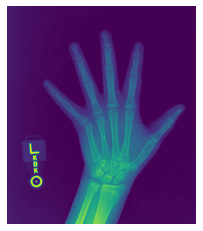

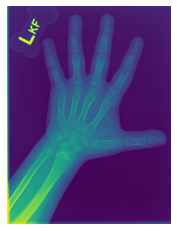

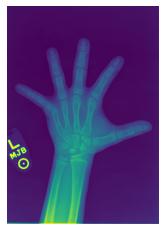

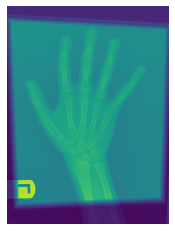

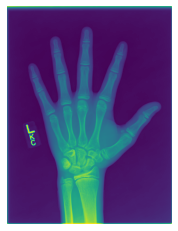

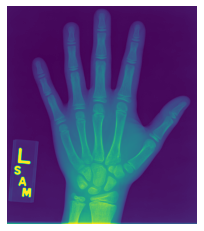

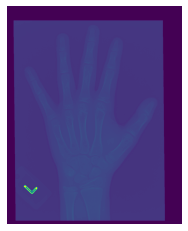

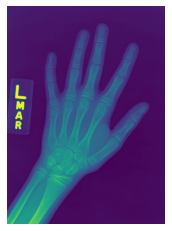

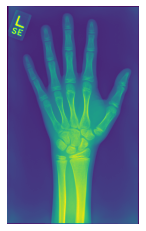

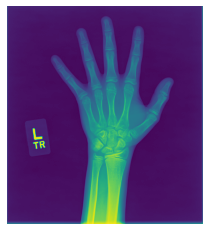

In [13]:
import matplotlib.image as mpimg #นำเข้า library ที่ใช้อ่านรูป
import matplotlib.pyplot as plt # เป็น module พื้นฐานที่ใช้ในการสร้างกราฟของ python
for filename, boneage, gender in train_dataset[['id','boneage','male']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ อายุ เพศ)
    train_img = mpimg.imread(os.path.join(path,'boneage_training_dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.imshow(train_img) # แสดงรูปภาพ
    plt.axis('off')
    plt.show()

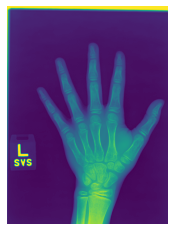

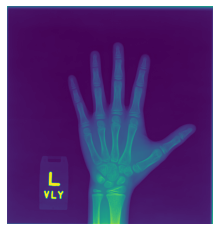

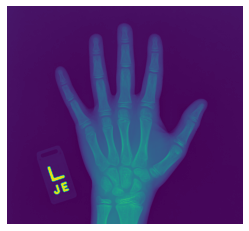

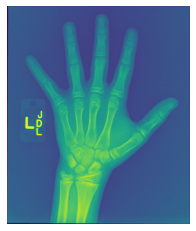

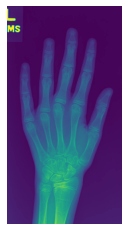

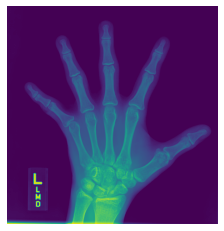

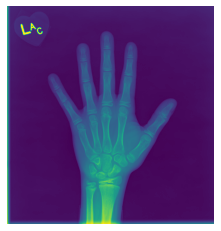

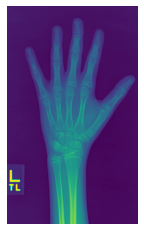

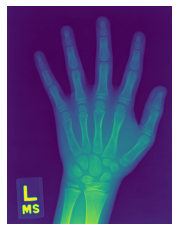

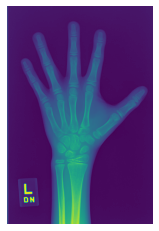

In [14]:
for filename, boneage, gender in validation_dataset[['id','boneage','male']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ อายุ เพศ)
    validation_img = mpimg.imread(os.path.join(path,'boneage_validation_dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.imshow(validation_img) # แสดงรูปภาพ
    plt.axis('off')
    plt.show()

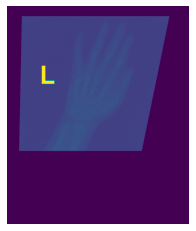

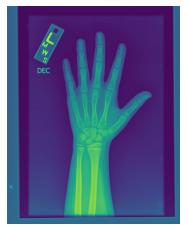

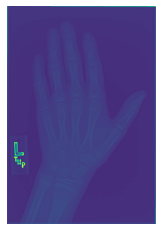

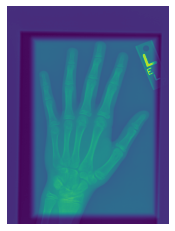

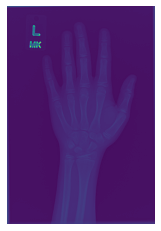

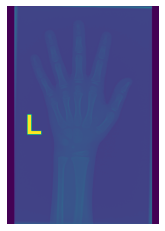

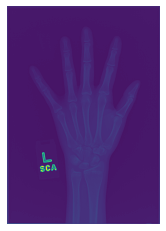

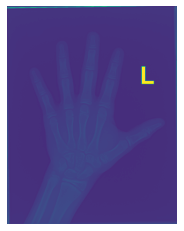

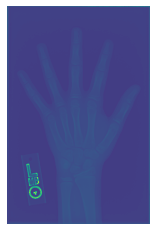

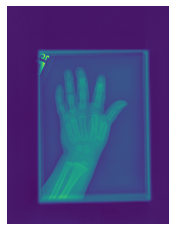

In [15]:
for filename, gender in test_dataset[['Case ID','Sex']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ เพศ)
    test_img = mpimg.imread(os.path.join(path,'boneage-test-dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.imshow(test_img) # แสดงรูปภาพ
    plt.axis('off')
    plt.show()

# Model

In [19]:
# Creating a CNN class
from __future__ import print_function
class Net(nn.Module):
   def __init__(self):
       super(Net, self).__init__()
       self.layer = torch.nn.Linear(1, 1)

   def forward(self, x):
       x = self.layer(x)      
       return x

net = Net()
print(net)

Net(
  (layer): Linear(in_features=1, out_features=1, bias=True)
)


In [27]:
x = train_dataset['id']
y = train_dataset['boneage']

In [28]:
# Define Optimizer and Loss Function
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()

# Training

In [30]:
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()
print(x, y)

TypeError: ignored

In [26]:
inputs = Variable(x)
outputs = Variable(y)
for i in range(250):
   prediction = net(inputs)
   loss = loss_func(prediction, outputs) 
   optimizer.zero_grad()
   loss.backward()        
   optimizer.step()       

   if i % 10 == 0:
       # plot and show learning process
       plt.cla()
       plt.scatter(x.data.numpy(), y.data.numpy())
       plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=2)
       plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})
       plt.pause(0.1)

plt.show()

NameError: ignored